In [1]:
# ============================================================================
# CELL 1: Import Required Libraries
## Enhanced Dental Practice Valuation Q&A Pipeline
# With Productivity and Procedures Data Integration

# ============================================================================
# CELL 1: Import Required Libraries
# ============================================================================

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import requests
from typing import Dict, List, Optional, Tuple, Any
import warnings
import re
from datetime import datetime
import os
warnings.filterwarnings('ignore')

# Set style for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# ============================================================================
# CELL 2: Configuration and API Setup
# ============================================================================

# OpenRouter API Configuration
OPENROUTER_API_KEY = "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"  # Replace with actual key (format: sk-or-v1-...)
OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"

# Model selection (free tier)
MODEL = "deepseek/deepseek-chat-v3-0324:free"  # Free model
# Alternative free models if needed:
# MODEL = "mistralai/mistral-7b-instruct:free"
# MODEL = "huggingfaceh4/zephyr-7b-beta:free"

# Headers for API requests - Updated for better compatibility
def get_headers():
    """Get headers with proper API key format"""
    return {
        "Authorization": f"Bearer {OPENROUTER_API_KEY}",
        "HTTP-Referer": "http://localhost:3000",  # Optional but recommended
        "X-Title": "Dental Practice Q&A",  # Optional
        "Content-Type": "application/json"
    }

headers = get_headers()

# Test API connection with better error reporting
def test_api_connection():
    """Test if the API key is valid and connection works"""
    if OPENROUTER_API_KEY == "your-api-key-here":
        print("⚠️ WARNING: API key not set! Please replace 'your-api-key-here' with your actual OpenRouter API key")
        print("Get your free API key from: https://openrouter.ai/keys")
        print("Format should be: sk-or-v1-xxxxxxxxxxxxx")
        return False
    
    if not OPENROUTER_API_KEY.startswith("sk-or-"):
        print("⚠️ WARNING: API key format might be incorrect.")
        print("OpenRouter keys typically start with 'sk-or-v1-'")
        print(f"Your key starts with: {OPENROUTER_API_KEY[:8]}...")
    
    try:
        print(f"Testing API connection with key: {OPENROUTER_API_KEY[:8]}...{OPENROUTER_API_KEY[-4:]}")
        
        test_response = requests.post(
            OPENROUTER_URL,
            headers=headers,
            json={
                "model": MODEL,
                "messages": [{"role": "user", "content": "Say 'connected'"}],
                "max_tokens": 10,
                "stream": False
            },
            timeout=10
        )
        
        print(f"Response status: {test_response.status_code}")
        
        if test_response.status_code == 200:
            print(f"✓ API configured successfully with model: {MODEL}")
            response_json = test_response.json()
            if 'choices' in response_json:
                print(f"✓ Test message received: {response_json['choices'][0]['message']['content']}")
            return True
        elif test_response.status_code == 401:
            print(f"✗ Authentication failed (401)")
            print(f"Response: {test_response.text}")
            print("\nTroubleshooting steps:")
            print("1. Check your API key is correct at: https://openrouter.ai/keys")
            print("2. Make sure the key is active and has credits")
            print("3. Try regenerating the key if it's not working")
            return False
        elif test_response.status_code == 402:
            print(f"✗ Insufficient credits (402)")
            print("Add credits at: https://openrouter.ai/credits")
            return False
        else:
            print(f"✗ API error: Status {test_response.status_code}")
            print(f"Response: {test_response.text}")
            return False
            
    except requests.exceptions.Timeout:
        print(f"✗ Connection timeout - API might be slow")
        return False
    except Exception as e:
        print(f"✗ Connection error: {e}")
        print("\nMake sure you have an internet connection and OpenRouter is accessible")
        return False

# Run the test
print("="*60)
print("OpenRouter API Configuration Test")
print("="*60)
api_connected = test_api_connection()

if not api_connected:
    print("\n" + "="*60)
    print("FALLBACK MODE ACTIVE")
    print("="*60)
    print("The system will work without the LLM and provide data-based analysis.")
    print("To enable LLM features:")
    print("1. Get a free API key from: https://openrouter.ai/keys")
    print("2. Replace 'your-api-key-here' with your actual key above")
    print("3. Run this cell again")
else:
    print("\n" + "="*60)
    print("SYSTEM READY")
    print("="*60)
    print("LLM features are enabled and working!")

OpenRouter API Configuration Test
Testing API connection with key: sk-or-v1...ad2d
Response status: 200
✓ API configured successfully with model: deepseek/deepseek-chat-v3-0324:free
✓ Test message received: Here you go:  

**Connected**  

Let

SYSTEM READY
LLM features are enabled and working!


In [3]:
# ============================================================================
# CELL 3: Enhanced Data Loading and Validation Functions
# ============================================================================

class DentalPracticeData:
    """Enhanced class to handle dental practice data from multiple sources"""
    
    def __init__(self, json_file_path: Optional[str] = None, 
                 productivity_csv: Optional[str] = None,
                 procedures_csv: Optional[str] = None,
                 data_dict: Optional[Dict] = None):
        """
        Initialize with JSON data and optional CSV files
        
        Args:
            json_file_path: Path to JSON file with financial data
            productivity_csv: Path to productivity CSV file
            procedures_csv: Path to procedures CSV file
            data_dict: Direct dictionary input (alternative to file)
        """
        # Load base financial data
        if json_file_path:
            with open(json_file_path, 'r') as f:
                self.data = json.load(f)
        elif data_dict:
            self.data = data_dict
        else:
            raise ValueError("Must provide either json_file_path or data_dict")
        
        # Load productivity data if provided
        self.productivity_data = None
        if productivity_csv:
            self.productivity_data = self._load_productivity_data(productivity_csv)
            
        # Load procedures data if provided
        self.procedures_data = None
        if procedures_csv:
            self.procedures_data = self._load_procedures_data(procedures_csv)
            
        # Validate and calculate metrics
        self._validate_required_fields()
        self._calculate_derived_metrics()
        self._add_simulated_data()
        
    def _load_productivity_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process productivity CSV data"""
        try:
            df = pd.read_csv(csv_path)
            
            # Handle column name variations
            # Rename provider_name to provider for consistency
            if 'provider_name' in df.columns and 'provider' not in df.columns:
                df = df.rename(columns={'provider_name': 'provider'})
            
            # Print actual columns for debugging
            print(f"Productivity CSV columns: {list(df.columns)}")
            
            # Clean numeric columns
            numeric_cols = ['patients_seen', 'avg_visit_fee', 'production', 
                           'collection', 'adjustments']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')
            
            print(f"Loaded productivity data: {len(df)} records")
            return df
        except Exception as e:
            print(f"Error loading productivity data: {e}")
            return None
    
    def _load_procedures_data(self, csv_path: str) -> pd.DataFrame:
        """Load and process procedures CSV data with regex cleaning"""
        try:
            df = pd.read_csv(csv_path)
            
            # Print actual columns for debugging
            print(f"Procedures CSV columns: {list(df.columns)}")
            
            # Clean service names using regex patterns
            if 'service' in df.columns:
                # Common cleaning patterns
                df['service_clean'] = df['service'].apply(self._clean_service_name)
                
                # Categorize services
                df['service_category'] = df['service_clean'].apply(self._categorize_service)
            
            # Clean numeric columns
            numeric_cols = ['number', 'amount']
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col].astype(str).str.replace('$', '').str.replace(',', ''), errors='coerce')
            
            print(f"Loaded procedures data: {len(df)} records")
            return df
        except Exception as e:
            print(f"Error loading procedures data: {e}")
            return None
    
    def _clean_service_name(self, service: str) -> str:
        """Clean service names using regex patterns"""
        if pd.isna(service):
            return "Unknown"
        
        service = str(service).strip()
        
        # Common patterns to clean
        patterns = [
            (r'^D\d{4}\s*-?\s*', ''),  # Remove procedure codes at start
            (r'\s+', ' '),  # Multiple spaces to single
            (r'[^\w\s-]', ''),  # Remove special characters except dash
            (r'^\s*-\s*', ''),  # Remove leading dashes
        ]
        
        for pattern, replacement in patterns:
            service = re.sub(pattern, replacement, service)
        
        # Standardize common terms
        replacements = {
            'xray': 'X-Ray',
            'x ray': 'X-Ray',
            'bitewing': 'Bitewing',
            'bw': 'Bitewing',
            'prophy': 'Prophylaxis',
            'exam': 'Examination',
            'perio': 'Periodontal',
        }
        
        service_lower = service.lower()
        for old, new in replacements.items():
            if old in service_lower:
                service = service.replace(service_lower, service_lower.replace(old, new.lower()))
                service = service.title()
                break
        
        return service if service else "Unknown"
    
    def _categorize_service(self, service: str) -> str:
        """Categorize services into major groups"""
        service_lower = service.lower()
        
        categories = {
            'Diagnostic': ['exam', 'x-ray', 'bitewing', 'panoramic', 'consult'],
            'Preventive': ['prophy', 'clean', 'fluoride', 'sealant'],
            'Restorative': ['filling', 'crown', 'bridge', 'composite', 'amalgam'],
            'Endodontic': ['root canal', 'endo', 'pulp'],
            'Periodontal': ['perio', 'scaling', 'root planing', 'gum'],
            'Oral Surgery': ['extraction', 'surgery', 'implant'],
            'Prosthodontic': ['denture', 'partial', 'prosth'],
            'Orthodontic': ['ortho', 'braces', 'aligner'],
        }
        
        for category, keywords in categories.items():
            if any(keyword in service_lower for keyword in keywords):
                return category
        
        return 'Other'
    
    def _add_simulated_data(self):
        """Add simulated data for demonstration purposes"""
        # Add location data (simulated)
        self.data['Location_Analysis'] = {
            'address': self.data.get('Practice_Overview', {}).get('Location', 'Unknown'),
            'demographics': {
                'population_5mi': 45000,
                'median_income': 75000,
                'growth_rate': '2.3%',
                'competitor_density': 'Medium (8 practices within 5mi)'
            },
            'accessibility_score': 8.5,  # Out of 10
            'visibility_score': 7.0,
            'parking_availability': 'Excellent',
            'public_transit': 'Good'
        }
        
        # Add staffing metrics (simulated)
        self.data['Staffing_Metrics'] = {
            'hygienist_ratio': 2.5,  # Hygienists per dentist
            'total_staff': 12,
            'overtime_percentage': 8.5,
            'staff_utilization': 85,
            'turnover_rate': 15,
            'satisfaction_score': 4.2  # Out of 5
        }
        
        # Add survey data (simulated)
        self.data['Survey_Data'] = {
            'patient_satisfaction': {
                'overall': 4.5,
                'wait_time': 4.2,
                'staff_friendliness': 4.7,
                'treatment_quality': 4.6,
                'value_for_money': 4.1
            },
            'doctor_feedback': {
                'equipment_quality': 'Modern and well-maintained',
                'practice_efficiency': 'Good, room for improvement in scheduling',
                'growth_potential': 'High - underserved pediatric market',
                'main_challenges': 'Staff retention, increasing competition'
            }
        }
        
        # Add P&L verification flags (simulated)
        self.data['Financial_Verification'] = {
            'p_and_l_verified': True,
            'verification_method': 'Bank statements and tax returns',
            'discrepancies_found': 'Minor - adjusted depreciation',
            'confidence_level': 'High (95%)'
        }
    
    def _validate_required_fields(self):
        """Validate that core required fields are present"""
        required_fields = ['Revenue_Trailing12', 'EBITDA_Trailing12']
        
        for field in required_fields:
            if field not in self.data:
                # Try to calculate from other data if possible
                if field == 'EBITDA_Trailing12' and 'Total_SDE' in self.data:
                    self.data['EBITDA_Trailing12'] = self.data['Total_SDE'] * 1.2
                else:
                    print(f"Warning: {field} not found in data")
    
    def _calculate_derived_metrics(self):
        """Calculate additional metrics from the data"""
        # Existing calculations
        if 'Revenue_Trailing12' in self.data and 'EBITDA_Trailing12' in self.data:
            self.data['EBITDA_Margin'] = (self.data['EBITDA_Trailing12'] / 
                                          self.data['Revenue_Trailing12']) * 100
        
        if 'Total_SDE' in self.data and 'Revenue_Trailing12' in self.data:
            self.data['SDE_Margin'] = (self.data['Total_SDE'] / 
                                       self.data['Revenue_Trailing12']) * 100
        
        # Calculate DSCR if debt service is available
        if 'Debt_Service_Annual' in self.data and 'EBITDA_Trailing12' in self.data:
            self.data['DSCR'] = self.data['EBITDA_Trailing12'] / self.data['Debt_Service_Annual']
        
        # Calculate productivity metrics if data available
        if self.productivity_data is not None and not self.productivity_data.empty:
            # Summary statistics
            self.data['Productivity_Summary'] = {
                'total_production': self.productivity_data['production'].sum() if 'production' in self.productivity_data.columns else 0,
                'total_collections': self.productivity_data['collection'].sum() if 'collection' in self.productivity_data.columns else 0,
                'collection_rate': (self.productivity_data['collection'].sum() / 
                                   self.productivity_data['production'].sum() * 100) if 'collection' in self.productivity_data.columns and 'production' in self.productivity_data.columns and self.productivity_data['production'].sum() > 0 else 0,
                'avg_patients_per_provider': self.productivity_data.groupby('provider')['patients_seen'].mean().mean() if 'provider' in self.productivity_data.columns and 'patients_seen' in self.productivity_data.columns else 0,
                'avg_visit_fee': self.productivity_data['avg_visit_fee'].mean() if 'avg_visit_fee' in self.productivity_data.columns else 0
            }
        
        # Calculate procedure metrics if data available
        if self.procedures_data is not None and not self.procedures_data.empty:
            # Top procedures by frequency and revenue
            if 'service_clean' in self.procedures_data.columns:
                if 'number' in self.procedures_data.columns:
                    top_by_freq = self.procedures_data.groupby('service_clean')['number'].sum().nlargest(10)
                else:
                    top_by_freq = pd.Series()
                    
                if 'amount' in self.procedures_data.columns:
                    top_by_revenue = self.procedures_data.groupby('service_clean')['amount'].sum().nlargest(10)
                else:
                    top_by_revenue = pd.Series()
                
                self.data['Procedures_Summary'] = {
                    'total_procedures': self.procedures_data['number'].sum() if 'number' in self.procedures_data.columns else 0,
                    'total_procedure_revenue': self.procedures_data['amount'].sum() if 'amount' in self.procedures_data.columns else 0,
                    'top_procedures_by_frequency': top_by_freq.to_dict() if not top_by_freq.empty else {},
                    'top_procedures_by_revenue': top_by_revenue.to_dict() if not top_by_revenue.empty else {},
                    'procedure_categories': self.procedures_data.groupby('service_category')['amount'].sum().to_dict() if 'service_category' in self.procedures_data.columns and 'amount' in self.procedures_data.columns else {}
                }
    
    def get_comprehensive_context(self) -> str:
        """Get all available data as a formatted string for LLM context"""
        context = f"""
        Practice: {self.data.get('Clinic', 'Unknown')}
        
        === FINANCIAL METRICS ===
        Revenue (Trailing 12): ${self.data.get('Revenue_Trailing12', 0):,.0f}
        EBITDA (Trailing 12): ${self.data.get('EBITDA_Trailing12', 0):,.0f}
        Total SDE: ${self.data.get('Total_SDE', 0):,.0f}
        EBITDA Margin: {self.data.get('EBITDA_Margin', 0):.1f}%
        SDE Margin: {self.data.get('SDE_Margin', 0):.1f}%
        
        === VALUATION ===
        EBITDA Multiple: {self.data.get('Valuation_Multiples', {}).get('EBITDA_multiple', 'N/A')}
        Revenue Multiple: {self.data.get('Valuation_Multiples', {}).get('Revenue_multiple', 'N/A')}
        
        === DEBT SERVICE ===
        Annual Debt Service: ${self.data.get('Debt_Service_Annual', 0):,.0f}
        DSCR: {self.data.get('DSCR', 0):.2f}
        """
        
        # Add productivity context if available
        if 'Productivity_Summary' in self.data:
            context += f"""
        
        === PRODUCTIVITY METRICS ===
        Total Production: ${self.data['Productivity_Summary']['total_production']:,.0f}
        Total Collections: ${self.data['Productivity_Summary']['total_collections']:,.0f}
        Collection Rate: {self.data['Productivity_Summary']['collection_rate']:.1f}%
        Avg Patients per Provider: {self.data['Productivity_Summary']['avg_patients_per_provider']:.0f}
        Average Visit Fee: ${self.data['Productivity_Summary']['avg_visit_fee']:.2f}
        """
        
        # Add procedures context if available
        if 'Procedures_Summary' in self.data:
            context += f"""
        
        === PROCEDURE METRICS ===
        Total Procedures: {self.data['Procedures_Summary']['total_procedures']:,.0f}
        Total Procedure Revenue: ${self.data['Procedures_Summary']['total_procedure_revenue']:,.0f}
        Top Service Categories: {', '.join(list(self.data['Procedures_Summary']['procedure_categories'].keys())[:5])}
        """
        
        # Add staffing metrics
        if 'Staffing_Metrics' in self.data:
            context += f"""
        
        === STAFFING METRICS ===
        Hygienist Ratio: {self.data['Staffing_Metrics']['hygienist_ratio']:.1f} per dentist
        Total Staff: {self.data['Staffing_Metrics']['total_staff']}
        Overtime Percentage: {self.data['Staffing_Metrics']['overtime_percentage']:.1f}%
        Staff Utilization: {self.data['Staffing_Metrics']['staff_utilization']}%
        Turnover Rate: {self.data['Staffing_Metrics']['turnover_rate']}%
        """
        
        # Add location analysis
        if 'Location_Analysis' in self.data:
            context += f"""
        
        === LOCATION ANALYSIS ===
        Address: {self.data['Location_Analysis']['address']}
        Population (5mi): {self.data['Location_Analysis']['demographics']['population_5mi']:,}
        Median Income: ${self.data['Location_Analysis']['demographics']['median_income']:,}
        Accessibility Score: {self.data['Location_Analysis']['accessibility_score']}/10
        Competitor Density: {self.data['Location_Analysis']['demographics']['competitor_density']}
        """
        
        # Add survey data
        if 'Survey_Data' in self.data:
            context += f"""
        
        === PATIENT & DOCTOR FEEDBACK ===
        Patient Satisfaction: {self.data['Survey_Data']['patient_satisfaction']['overall']}/5
        Doctor Assessment: {self.data['Survey_Data']['doctor_feedback']['growth_potential']}
        Main Challenges: {self.data['Survey_Data']['doctor_feedback']['main_challenges']}
        """
        
        # Add P&L verification
        if 'Financial_Verification' in self.data:
            context += f"""
        
        === FINANCIAL VERIFICATION ===
        P&L Verified: {self.data['Financial_Verification']['p_and_l_verified']}
        Verification Method: {self.data['Financial_Verification']['verification_method']}
        Confidence Level: {self.data['Financial_Verification']['confidence_level']}
        """
        
        # Add SWOT if available
        if 'SWOT' in self.data:
            context += f"""
        
        === SWOT ANALYSIS ===
        Strengths: {', '.join(self.data['SWOT'].get('Strengths', [])[:3])}
        Weaknesses: {', '.join(self.data['SWOT'].get('Weaknesses', [])[:3])}
        Opportunities: {', '.join(self.data['SWOT'].get('Opportunities', [])[:3])}
        Threats: {', '.join(self.data['SWOT'].get('Threats', [])[:3])}
        """
        
        return context

In [4]:
# ============================================================================
# CELL 4: Enhanced LLM Interaction Functions
# ============================================================================

def categorize_question(question: str) -> str:
    """Enhanced question categorization with new categories"""
    question_lower = question.lower()
    
    # Extended category mappings
    category_keywords = {
        'productivity': ['productivity', 'production', 'collection', 'efficiency', 
                        'patients seen', 'visit fee', 'utilization'],
        'procedures': ['procedure', 'service', 'treatment', 'bitewing', 'crown',
                      'filling', 'exam', 'frequency', 'procedure mix'],
        'staffing': ['hygienist', 'staff', 'overtime', 'employee', 'turnover',
                    'ratio', 'utilization', 'satisfaction'],
        'location': ['location', 'address', 'demographics', 'population', 
                    'competition', 'accessibility', 'area'],
        'verification': ['verify', 'real', 'authentic', 'accurate', 'p&l',
                        'verification', 'confidence', 'discrepancy'],
        'sde': ['sde', 'seller discretionary', 'add-back', 'adjustment'],
        'valuation': ['valuation', 'multiple', 'worth', 'value', 'price'],
        'tax': ['tax', 'depreciation', 'amortization', 'write'],
        'pnl': ['p&l', 'profit', 'loss', 'income statement', 'expense'],
        'swot': ['strength', 'weakness', 'opportunity', 'threat', 'swot'],
        'operations': ['operations', 'patient', 'appointment', 'schedule', 'technology'],
        'debt': ['debt', 'loan', 'dscr', 'coverage', 'service'],
        'survey': ['survey', 'feedback', 'satisfaction', 'patient experience']
    }
    
    for category, keywords in category_keywords.items():
        if any(keyword in question_lower for keyword in keywords):
            return category
    
    return 'general'

def detect_provider_in_question(question: str, practice_data: DentalPracticeData) -> Optional[str]:
    """Detect if a specific provider is mentioned in the question"""
    if practice_data.productivity_data is None and practice_data.procedures_data is None:
        return None
    
    # Get list of all providers from available data
    providers = set()
    if practice_data.productivity_data is not None and 'provider' in practice_data.productivity_data.columns:
        providers.update(practice_data.productivity_data['provider'].dropna().unique())
    if practice_data.procedures_data is not None and 'provider' in practice_data.procedures_data.columns:
        providers.update(practice_data.procedures_data['provider'].dropna().unique())
    
    question_lower = question.lower()
    best_match = None
    best_score = 0
    
    # Check each provider for matches
    for provider in providers:
        provider_lower = provider.lower()
        score = 0
        
        # Check for full name match (highest priority)
        if provider_lower in question_lower:
            return provider  # Exact match found, return immediately
        
        # Check for partial matches with word boundaries
        provider_parts = provider.split()
        for part in provider_parts:
            if len(part) > 2:  # Skip short parts like "S."
                # Use word boundary check to avoid false matches like "Chang" in "change"
                import re
                pattern = r'\b' + re.escape(part.lower()) + r'\b'
                if re.search(pattern, question_lower):
                    score += 1
        
        # Keep track of best match
        if score > best_score:
            best_score = score
            best_match = provider
    
    # Return best match if we found at least 2 matching parts (e.g., first and last name)
    if best_score >= 2:
        return best_match
    
    return None

def generate_llm_prompt(question: str, practice_data: DentalPracticeData, category: str, provider_name: Optional[str] = None) -> str:
    """Generate a prompt that encourages analytical insights from the LLM"""
    
    prompt = "You are an expert dental practice analyst providing insights to practice owners and potential buyers.\n\n"
    
    # Include ALL provider data for comparison purposes
    prompt += "=== COMPLETE PRACTICE DATA ===\n\n"
    
    # Add all productivity data for context and comparisons
    if practice_data.productivity_data is not None and not practice_data.productivity_data.empty:
        prompt += "ALL PRODUCTIVITY DATA (for comparison):\n"
        # Summarize by provider for easier comparison
        summary = practice_data.productivity_data.groupby(['provider', 'year']).agg({
            'production': 'sum',
            'collection': 'sum',
            'patients_seen': 'sum',
            'avg_visit_fee': 'mean'
        }).round(2)
        prompt += summary.to_string()
        prompt += "\n\n"
    
    # If asking about a specific provider, highlight their data
    if provider_name:
        prompt += f"=== SPECIFIC DATA FOR {provider_name.upper()} ===\n"
        
        if practice_data.productivity_data is not None:
            provider_data = practice_data.productivity_data[
                practice_data.productivity_data['provider'] == provider_name
            ]
            if not provider_data.empty:
                prompt += "DETAILED RECORDS:\n"
                prompt += provider_data.to_string(index=False)
                prompt += "\n\n"
    
    # Add practice overview
    prompt += "=== PRACTICE OVERVIEW ===\n"
    if 'Revenue_Trailing12' in practice_data.data:
        prompt += f"Total Practice Revenue: ${practice_data.data['Revenue_Trailing12']:,.0f}\n"
    if 'EBITDA_Trailing12' in practice_data.data:
        prompt += f"Practice EBITDA: ${practice_data.data['EBITDA_Trailing12']:,.0f}\n"
    prompt += "\n"
    
    # Add the question
    prompt += f"=== QUESTION ===\n{question}\n\n"
    
    # Enhanced instructions for insights - MORE FOCUSED
    prompt += """=== INSTRUCTIONS ===

CRITICAL: Focus ONLY on the specific metric asked about in the question.

- If asked about "productivity trend" → Focus ONLY on production dollars
- If asked about "collection rates" → Focus ONLY on collections
- If asked about "patient volume" → Focus ONLY on patient counts
- If asked about "average visit fee" → Focus ONLY on fees

Structure your response as:

1. **Direct Answer**: The specific metric requested with year-over-year changes

2. **Comparative Context** (for that metric only):
   - How this provider compares to others ON THIS SPECIFIC METRIC
   - Is this provider above/below average FOR THIS METRIC
   - Any notable patterns IN THIS METRIC

3. **Key Insights** (about this metric only):
   - What the trend means for the practice
   - Any concerns or strengths RELATED TO THIS METRIC
   - Business implications OF THIS SPECIFIC TREND

4. **Suggested Follow-ups** (2-3 related questions):
   - Questions that would provide additional context
   - Related metrics they might want to explore

DO NOT include information about other metrics unless they directly explain the requested metric.
Keep the analysis focused and actionable.

Please provide your focused analytical response:"""
    
    return prompt
    """Generate enhanced prompt based on question category and available data"""
    
    # Start with the base context
    context = practice_data.get_comprehensive_context()
    
    # Add provider-specific ACTUAL DATA if a provider was detected
    if provider_name:
        provider_context = f"\n\n=== SPECIFIC DATA FOR {provider_name.upper()} ===\n"
        data_found = False
        
        if practice_data.productivity_data is not None:
            provider_prod = practice_data.productivity_data[
                practice_data.productivity_data['provider'] == provider_name
            ]
            if not provider_prod.empty:
                data_found = True
                provider_context += f"\nPRODUCTIVITY DATA:\n"
                
                # Get the role
                if 'service_role' in provider_prod.columns:
                    role = provider_prod['service_role'].iloc[0]
                    provider_context += f"Role: {role}\n"
                
                # Provide ALL the actual data
                yearly_data = provider_prod.groupby('year').agg({
                    col: 'sum' if col in ['production', 'collection', 'patients_seen', 'adjustments'] else 'mean'
                    for col in provider_prod.columns if col in ['production', 'collection', 'patients_seen', 'avg_visit_fee', 'adjustments']
                }).round(2)
                
                provider_context += "\nYear-by-Year Data:\n"
                for year in yearly_data.index:
                    provider_context += f"\n{year}:\n"
                    if 'production' in yearly_data.columns:
                        provider_context += f"  - Production: ${yearly_data.loc[year, 'production']:,.2f}\n"
                    if 'collection' in yearly_data.columns:
                        provider_context += f"  - Collections: ${yearly_data.loc[year, 'collection']:,.2f}\n"
                    if 'patients_seen' in yearly_data.columns:
                        provider_context += f"  - Patients Seen: {int(yearly_data.loc[year, 'patients_seen'])}\n"
                    if 'avg_visit_fee' in yearly_data.columns:
                        provider_context += f"  - Average Visit Fee: ${yearly_data.loc[year, 'avg_visit_fee']:.2f}\n"
                    if 'adjustments' in yearly_data.columns:
                        provider_context += f"  - Adjustments: ${yearly_data.loc[year, 'adjustments']:,.2f}\n"
                
                # Overall statistics
                provider_context += f"\nOVERALL STATISTICS:\n"
                if 'production' in provider_prod.columns:
                    provider_context += f"  - Total Production (all years): ${provider_prod['production'].sum():,.2f}\n"
                if 'collection' in provider_prod.columns:
                    provider_context += f"  - Total Collections (all years): ${provider_prod['collection'].sum():,.2f}\n"
                if 'patients_seen' in provider_prod.columns:
                    provider_context += f"  - Total Patients (all years): {provider_prod['patients_seen'].sum():.0f}\n"
                if 'avg_visit_fee' in provider_prod.columns:
                    provider_context += f"  - Average Visit Fee (overall): ${provider_prod['avg_visit_fee'].mean():.2f}\n"
                    provider_context += f"  - Min Visit Fee: ${provider_prod['avg_visit_fee'].min():.2f}\n"
                    provider_context += f"  - Max Visit Fee: ${provider_prod['avg_visit_fee'].max():.2f}\n"
        
        if practice_data.procedures_data is not None and 'provider' in practice_data.procedures_data.columns:
            provider_proc = practice_data.procedures_data[
                practice_data.procedures_data['provider'] == provider_name
            ]
            if not provider_proc.empty:
                data_found = True
                provider_context += f"\n\nPROCEDURE DATA:\n"
                provider_context += f"Total Procedures Performed: {provider_proc['number'].sum() if 'number' in provider_proc.columns else 'N/A'}\n"
                provider_context += f"Total Procedure Revenue: ${provider_proc['amount'].sum():,.2f if 'amount' in provider_proc.columns else 0}\n"
                
                if 'service_clean' in provider_proc.columns and 'amount' in provider_proc.columns:
                    top_procedures = provider_proc.groupby('service_clean')['amount'].sum().nlargest(10)
                    provider_context += f"\nTop 10 Procedures by Revenue:\n"
                    for i, (proc, amount) in enumerate(top_procedures.items(), 1):
                        provider_context += f"  {i}. {proc}: ${amount:,.2f}\n"
        
        if not data_found:
            provider_context += f"\nNO DATA FOUND for {provider_name} in the CSV files.\n"
        
        context = provider_context + "\n" + context
    
    # Create the prompt with clear instructions
    base_prompt = f"""You are a dental practice valuation expert. You have been provided with ACTUAL DATA from CSV files about the practice and specific providers.

IMPORTANT: Base your answer ONLY on the actual data provided above. Do not make assumptions or use industry averages unless explicitly stated that data is missing.

DATA PROVIDED:
{context}

Question: {question}

Instructions:
1. Answer using ONLY the specific numbers from the data provided above
2. If asking about a specific metric (like average visit fee), provide the exact number from the data
3. Do not guess or estimate - use the actual values
4. If data is missing, explicitly state "Data not available" rather than estimating
5. For trend questions, show the year-by-year progression using the actual data

Please provide a clear, specific answer using the actual data."""
    
    return base_prompt

def get_llm_response(prompt: str, max_retries: int = 3) -> str:
    """Get response from the LLM API with retry logic"""
    # Check if API key is set
    if OPENROUTER_API_KEY == "your-api-key-here":
        return "⚠️ API key not configured. Please set your OpenRouter API key in Cell 2."
    
    import time
    
    # Get fresh headers for each request
    headers = get_headers()
    
    for attempt in range(max_retries):
        try:
            print(f"Calling LLM API (attempt {attempt + 1}/{max_retries})...")
            
            # Add timeout and better error handling
            response = requests.post(
                OPENROUTER_URL,
                headers=headers,
                json={
                    "model": MODEL,
                    "messages": [
                        {"role": "system", "content": "You are an expert dental practice analyst. Provide insights, comparisons, and actionable recommendations based on data. Don't just list numbers - explain what they mean and suggest next steps."},
                        {"role": "user", "content": prompt}
                    ],
                    "temperature": 0.3,  # Lower temperature for more factual responses
                    "max_tokens": 4000,  # Increased significantly to prevent cutoff
                    "stream": False  # Explicitly disable streaming
                },
                timeout=30  # 30 second timeout
            )
            
            print(f"API Response Status: {response.status_code}")
            
            if response.status_code == 200:
                response_json = response.json()
                if 'choices' in response_json and len(response_json['choices']) > 0:
                    full_response = response_json['choices'][0]['message']['content']
                    # Check if response was cut off
                    if 'finish_reason' in response_json['choices'][0]:
                        if response_json['choices'][0]['finish_reason'] == 'length':
                            full_response += "\n\n[Note: Response was truncated due to length limit]"
                    return full_response
                else:
                    return f"Error: Unexpected API response format. Response: {response_json}"
            
            elif response.status_code == 401:
                # Authentication error - don't retry
                return f"Authentication Error: Please check your API key in Cell 2. The key should start with 'sk-or-v1-'"
            
            elif response.status_code == 402:
                # No credits - don't retry
                return f"Insufficient Credits: Please add credits to your OpenRouter account at https://openrouter.ai/credits"
            
            elif response.status_code == 429:
                # Rate limit - wait and retry
                wait_time = (attempt + 1) * 2
                print(f"Rate limited. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
                continue
                
            elif response.status_code == 502 or response.status_code == 503:
                # Server error - wait and retry
                wait_time = (attempt + 1) * 2
                print(f"Server error. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
                continue
                
            else:
                return f"Error: API returned status code {response.status_code}. Response: {response.text}"
        
        except requests.exceptions.Timeout:
            print(f"Request timed out on attempt {attempt + 1}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return "Error: Request timed out after multiple attempts. Using fallback analysis."
        
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return f"Error: Connection failed after {max_retries} attempts. Using fallback analysis."
        
        except Exception as e:
            print(f"Unexpected error on attempt {attempt + 1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return f"Error calling LLM API: {str(e)}. Using fallback analysis."
    
    return "Error: Failed to get LLM response after all retries. Using fallback analysis."
    """Get response from the LLM API with retry logic"""
    # Check if API key is set
    if OPENROUTER_API_KEY == "your-api-key-here":
        return "⚠️ API key not configured. Please set your OpenRouter API key in Cell 2."
    
    import time
    
    # Get fresh headers for each request
    headers = get_headers()
    
    for attempt in range(max_retries):
        try:
            print(f"Calling LLM API (attempt {attempt + 1}/{max_retries})...")
            
            # Add timeout and better error handling
            response = requests.post(
                OPENROUTER_URL,
                headers=headers,
                json={
                    "model": MODEL,
                    "messages": [
                        {"role": "system", "content": "You are a dental practice valuation expert. Answer based ONLY on the actual data provided. Do not estimate or guess."},
                        {"role": "user", "content": prompt}
                    ],
                    "temperature": 0.3,  # Lower temperature for more factual responses
                    "max_tokens": 2000,  # Increased for complete responses
                    "stream": False  # Explicitly disable streaming
                },
                timeout=30  # 30 second timeout
            )
            
            print(f"API Response Status: {response.status_code}")
            
            if response.status_code == 200:
                response_json = response.json()
                if 'choices' in response_json and len(response_json['choices']) > 0:
                    full_response = response_json['choices'][0]['message']['content']
                    # Check if response was cut off
                    if 'finish_reason' in response_json['choices'][0]:
                        if response_json['choices'][0]['finish_reason'] == 'length':
                            full_response += "\n\n[Note: Response was truncated due to length limit]"
                    return full_response
                else:
                    return f"Error: Unexpected API response format. Response: {response_json}"
            
            elif response.status_code == 401:
                # Authentication error - don't retry
                return f"Authentication Error: Please check your API key in Cell 2. The key should start with 'sk-or-v1-'"
            
            elif response.status_code == 402:
                # No credits - don't retry
                return f"Insufficient Credits: Please add credits to your OpenRouter account at https://openrouter.ai/credits"
            
            elif response.status_code == 429:
                # Rate limit - wait and retry
                wait_time = (attempt + 1) * 2
                print(f"Rate limited. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
                continue
                
            elif response.status_code == 502 or response.status_code == 503:
                # Server error - wait and retry
                wait_time = (attempt + 1) * 2
                print(f"Server error. Waiting {wait_time} seconds before retry...")
                time.sleep(wait_time)
                continue
                
            else:
                return f"Error: API returned status code {response.status_code}. Response: {response.text}"
        
        except requests.exceptions.Timeout:
            print(f"Request timed out on attempt {attempt + 1}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return "Error: Request timed out after multiple attempts. Using fallback analysis."
        
        except requests.exceptions.ConnectionError as e:
            print(f"Connection error on attempt {attempt + 1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return f"Error: Connection failed after {max_retries} attempts. Using fallback analysis."
        
        except Exception as e:
            print(f"Unexpected error on attempt {attempt + 1}: {str(e)}")
            if attempt < max_retries - 1:
                time.sleep(2)
                continue
            else:
                return f"Error calling LLM API: {str(e)}. Using fallback analysis."
    
    return "Error: Failed to get LLM response after all retries. Using fallback analysis."

In [5]:
# ============================================================================
# CELL 5: Enhanced Visualization Generation Functions
# ============================================================================

def create_productivity_dashboard(practice_data: DentalPracticeData) -> go.Figure:
    """Create comprehensive productivity dashboard"""
    if practice_data.productivity_data is None:
        return None
    
    df = practice_data.productivity_data
    
    # Check which columns are actually available
    has_year = 'year' in df.columns
    has_provider = 'provider' in df.columns
    has_production = 'production' in df.columns
    has_collection = 'collection' in df.columns
    has_patients = 'patients_seen' in df.columns
    has_visit_fee = 'avg_visit_fee' in df.columns
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('Production by Year', 'Collection Rate Trend', 
                       'Provider Performance', 'Patients Seen Trend',
                       'Production vs Collections', 'Average Visit Fee'),
        specs=[[{'type': 'bar'}, {'type': 'scatter'}, {'type': 'bar'}],
               [{'type': 'scatter'}, {'type': 'scatter'}, {'type': 'box'}]]
    )
    
    # 1. Production by Year (if year and production columns exist)
    if has_year and has_production:
        yearly_prod = df.groupby('year')['production'].sum()
        fig.add_trace(
            go.Bar(x=yearly_prod.index, y=yearly_prod.values, name='Production',
                   marker_color='lightblue'),
            row=1, col=1
        )
    
    # 2. Collection Rate Trend (if year, production and collection exist)
    if has_year and has_production and has_collection:
        yearly_stats = df.groupby('year').agg({
            'production': 'sum',
            'collection': 'sum'
        })
        yearly_stats['collection_rate'] = (yearly_stats['collection'] / 
                                           yearly_stats['production'] * 100)
        fig.add_trace(
            go.Scatter(x=yearly_stats.index, y=yearly_stats['collection_rate'],
                      mode='lines+markers', name='Collection %',
                      line=dict(color='green', width=2)),
            row=1, col=2
        )
    
    # 3. Provider Performance (if provider and production exist)
    if has_provider and has_production:
        provider_prod = df.groupby('provider')['production'].sum().nlargest(10)
        fig.add_trace(
            go.Bar(x=provider_prod.values, y=provider_prod.index,
                   orientation='h', name='Provider Production',
                   marker_color='coral'),
            row=1, col=3
        )
    
    # 4. Patients Seen Trend (if year and patients_seen exist)
    if has_year and has_patients:
        yearly_patients = df.groupby('year')['patients_seen'].sum()
        fig.add_trace(
            go.Scatter(x=yearly_patients.index, y=yearly_patients.values,
                      mode='lines+markers', name='Patients',
                      line=dict(color='purple', width=2)),
            row=2, col=1
        )
    
    # 5. Production vs Collections (if both exist)
    if has_production and has_collection:
        fig.add_trace(
            go.Scatter(x=df['production'], y=df['collection'],
                      mode='markers', name='Prod vs Coll',
                      marker=dict(size=5, color='orange')),
            row=2, col=2
        )
    
    # 6. Average Visit Fee Distribution (if exists)
    if has_visit_fee:
        fig.add_trace(
            go.Box(y=df['avg_visit_fee'], name='Visit Fee',
                   marker_color='lightgreen'),
            row=2, col=3
        )
    
    # Update layout
    fig.update_layout(
        title_text="Productivity Analysis Dashboard",
        showlegend=False,
        height=700,
        template='plotly_white'
    )
    
    return fig

def create_procedures_dashboard(practice_data: DentalPracticeData) -> go.Figure:
    """Create comprehensive procedures dashboard"""
    if practice_data.procedures_data is None:
        return None
    
    df = practice_data.procedures_data
    
    # Check which columns are actually available
    has_year = 'year' in df.columns
    has_provider = 'provider' in df.columns
    has_service = 'service_clean' in df.columns
    has_category = 'service_category' in df.columns
    has_number = 'number' in df.columns
    has_amount = 'amount' in df.columns
    
    # Create subplots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('Top Procedures by Frequency', 'Top Procedures by Revenue',
                       'Service Category Distribution', 'Provider Procedure Mix',
                       'Bitewing Analysis', 'Procedure Trends'),
        specs=[[{'type': 'bar'}, {'type': 'bar'}, {'type': 'pie'}],
               [{'type': 'bar'}, {'type': 'bar'}, {'type': 'scatter'}]]
    )
    
    # 1. Top Procedures by Frequency
    if has_service and has_number:
        top_freq = df.groupby('service_clean')['number'].sum().nlargest(10)
        fig.add_trace(
            go.Bar(x=top_freq.values, y=top_freq.index,
                   orientation='h', marker_color='lightblue'),
            row=1, col=1
        )
    
    # 2. Top Procedures by Revenue
    if has_service and has_amount:
        top_rev = df.groupby('service_clean')['amount'].sum().nlargest(10)
        fig.add_trace(
            go.Bar(x=top_rev.values, y=top_rev.index,
                   orientation='h', marker_color='lightcoral'),
            row=1, col=2
        )
    
    # 3. Service Category Distribution
    if has_category and has_amount:
        cat_dist = df.groupby('service_category')['amount'].sum()
        fig.add_trace(
            go.Pie(labels=cat_dist.index, values=cat_dist.values),
            row=1, col=3
        )
    
    # 4. Provider Procedure Mix
    if has_provider and has_amount:
        provider_mix = df.groupby('provider')['amount'].sum().nlargest(10)
        fig.add_trace(
            go.Bar(x=provider_mix.index, y=provider_mix.values,
                   marker_color='lightgreen'),
            row=2, col=1
        )
    
    # 5. Bitewing Analysis
    if has_service and has_year and has_amount:
        bitewing_data = df[df['service_clean'].str.contains('Bitewing', case=False, na=False)]
        if not bitewing_data.empty:
            bitewing_by_year = bitewing_data.groupby('year')['amount'].sum()
            fig.add_trace(
                go.Bar(x=bitewing_by_year.index, y=bitewing_by_year.values,
                       marker_color='orange'),
                row=2, col=2
            )
    
    # 6. Procedure Trends
    if has_year and has_number:
        yearly_procedures = df.groupby('year')['number'].sum()
        fig.add_trace(
            go.Scatter(x=yearly_procedures.index, y=yearly_procedures.values,
                      mode='lines+markers', line=dict(color='purple', width=2)),
            row=2, col=3
        )
    
    # Update layout
    fig.update_layout(
        title_text="Procedures Analysis Dashboard",
        showlegend=False,
        height=700,
        template='plotly_white'
    )
    
    return fig

def create_staffing_visualization(practice_data: DentalPracticeData) -> go.Figure:
    """Create staffing metrics visualization"""
    if 'Staffing_Metrics' not in practice_data.data:
        return None
    
    metrics = practice_data.data['Staffing_Metrics']
    
    # Create gauge charts for key metrics
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('Hygienist Ratio', 'Staff Utilization', 'Overtime %',
                       'Turnover Rate', 'Satisfaction Score', 'Staff Composition'),
        specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'indicator'}],
               [{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'pie'}]]
    )
    
    # Hygienist Ratio (ideal: 1.5-2.0)
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=metrics['hygienist_ratio'],
            title={'text': "per Dentist"},
            gauge={'axis': {'range': [None, 4]},
                   'bar': {'color': "darkblue"},
                   'steps': [
                       {'range': [0, 1.5], 'color': "lightgray"},
                       {'range': [1.5, 2.0], 'color': "lightgreen"},
                       {'range': [2.0, 4], 'color': "lightgray"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 2.0}}),
        row=1, col=1
    )
    
    # Staff Utilization (ideal: 85-90%)
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=metrics['staff_utilization'],
            title={'text': "Utilization %"},
            gauge={'axis': {'range': [None, 100]},
                   'bar': {'color': "darkgreen"},
                   'steps': [
                       {'range': [0, 70], 'color': "lightgray"},
                       {'range': [70, 85], 'color': "yellow"},
                       {'range': [85, 90], 'color': "lightgreen"},
                       {'range': [90, 100], 'color': "orange"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 87.5}}),
        row=1, col=2
    )
    
    # Overtime % (ideal: <5%)
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=metrics['overtime_percentage'],
            title={'text': "Overtime %"},
            gauge={'axis': {'range': [None, 20]},
                   'bar': {'color': "darkorange"},
                   'steps': [
                       {'range': [0, 5], 'color': "lightgreen"},
                       {'range': [5, 10], 'color': "yellow"},
                       {'range': [10, 20], 'color': "lightcoral"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 5}}),
        row=1, col=3
    )
    
    # Turnover Rate (ideal: <10%)
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=metrics['turnover_rate'],
            title={'text': "Turnover %"},
            gauge={'axis': {'range': [None, 30]},
                   'bar': {'color': "darkred"},
                   'steps': [
                       {'range': [0, 10], 'color': "lightgreen"},
                       {'range': [10, 20], 'color': "yellow"},
                       {'range': [20, 30], 'color': "lightcoral"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 10}}),
        row=2, col=1
    )
    
    # Satisfaction Score (out of 5)
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=metrics['satisfaction_score'],
            title={'text': "Satisfaction /5"},
            gauge={'axis': {'range': [None, 5]},
                   'bar': {'color': "purple"},
                   'steps': [
                       {'range': [0, 3], 'color': "lightcoral"},
                       {'range': [3, 4], 'color': "yellow"},
                       {'range': [4, 5], 'color': "lightgreen"}],
                   'threshold': {'line': {'color': "red", 'width': 4},
                                'thickness': 0.75, 'value': 4}}),
        row=2, col=2
    )
    
    # Staff Composition Pie Chart
    staff_comp = {
        'Dentists': 2,
        'Hygienists': 5,
        'Assistants': 3,
        'Admin': 2
    }
    fig.add_trace(
        go.Pie(labels=list(staff_comp.keys()), values=list(staff_comp.values()),
               hole=0.3),
        row=2, col=3
    )
    
    fig.update_layout(
        title_text="Staffing Metrics Dashboard",
        showlegend=False,
        height=600,
        template='plotly_white'
    )
    
    return fig

def create_location_analysis(practice_data: DentalPracticeData) -> go.Figure:
    """Create location analysis visualization"""
    if 'Location_Analysis' not in practice_data.data:
        return None
    
    location = practice_data.data['Location_Analysis']
    
    # Create a comprehensive location assessment
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Location Scores', 'Demographics', 
                       'Competition Analysis', 'Growth Potential'),
        specs=[[{'type': 'bar'}, {'type': 'indicator'}],
               [{'type': 'pie'}, {'type': 'scatter'}]]
    )
    
    # Location Scores
    scores = {
        'Accessibility': location['accessibility_score'],
        'Visibility': location['visibility_score'],
        'Overall': (location['accessibility_score'] + location['visibility_score']) / 2
    }
    fig.add_trace(
        go.Bar(x=list(scores.keys()), y=list(scores.values()),
               marker_color=['lightblue', 'lightgreen', 'coral'],
               text=[f"{v:.1f}" for v in scores.values()],
               textposition='auto'),
        row=1, col=1
    )
    
    # Demographics Indicator
    fig.add_trace(
        go.Indicator(
            mode="number+delta",
            value=location['demographics']['median_income'],
            title={'text': "Median Income"},
            delta={'reference': 65000, 'relative': True},
            number={'prefix': "$", 'valueformat': ",.0f"}),
        row=1, col=2
    )
    
    # Competition Analysis (simulated data)
    competition = {
        'Low Competition': 20,
        'Moderate Competition': 50,
        'High Competition': 30
    }
    fig.add_trace(
        go.Pie(labels=list(competition.keys()), values=list(competition.values()),
               marker_colors=['green', 'yellow', 'red']),
        row=2, col=1
    )
    
    # Growth Potential (simulated trend)
    years = [2022, 2023, 2024, 2025, 2026]
    population = [42000, 43000, 44000, 45000, 46500]
    fig.add_trace(
        go.Scatter(x=years, y=population, mode='lines+markers',
                  line=dict(color='purple', width=2),
                  marker=dict(size=8)),
        row=2, col=2
    )
    
    fig.update_layout(
        title_text="Location Analysis Dashboard",
        showlegend=False,
        height=600,
        template='plotly_white'
    )
    
    return fig

def create_smart_visualization(practice_data: DentalPracticeData, question: str, answer: str = "") -> go.Figure:
    """Create a simple, relevant visualization based on the question"""
    
    question_lower = question.lower()
    
    # Detect provider if mentioned
    provider_name = detect_provider_in_question(question, practice_data)
    
    # Determine what type of data to visualize
    if provider_name and practice_data.productivity_data is not None:
        # Filter to provider's data
        df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
        
        if df.empty:
            return None
        
        # Determine what metric to show based on keywords in question
        metric = None
        title = None
        
        if 'visit fee' in question_lower:
            metric = 'avg_visit_fee'
            title = 'Average Visit Fee'
        elif 'production' in question_lower or 'productivity' in question_lower:
            metric = 'production'
            title = 'Production'
        elif 'collection' in question_lower:
            metric = 'collection'
            title = 'Collections'
        elif 'patient' in question_lower:
            metric = 'patients_seen'
            title = 'Patients Seen'
        
        # If we identified a metric, create a simple visualization
        if metric and metric in df.columns and 'year' in df.columns:
            # Group by year and aggregate
            if metric in ['production', 'collection', 'patients_seen', 'adjustments']:
                yearly_data = df.groupby('year')[metric].sum().sort_index()
            else:
                yearly_data = df.groupby('year')[metric].mean().sort_index()
            
            # Create simple line or bar chart
            fig = go.Figure()
            
            if 'trend' in question_lower or len(yearly_data) > 2:
                # Line chart for trends
                fig.add_trace(go.Scatter(
                    x=yearly_data.index,
                    y=yearly_data.values,
                    mode='lines+markers',
                    line=dict(width=3),
                    marker=dict(size=10)
                ))
            else:
                # Bar chart for comparisons
                fig.add_trace(go.Bar(
                    x=yearly_data.index,
                    y=yearly_data.values
                ))
            
            fig.update_layout(
                title=f"{title} - {provider_name}",
                xaxis_title="Year",
                yaxis_title=title,
                template='plotly_white',
                height=400
            )
            
            return fig
    
    # If no specific visualization needed, return None
    return None
    """Create a smart visualization based on the question and answer context"""
    
    question_lower = question.lower()
    
    # Detect what specific metric is being asked about
    if 'average visit fee' in question_lower or 'avg visit fee' in question_lower:
        # Show only average visit fee
        provider_name = detect_provider_in_question(question, practice_data)
        
        if provider_name and practice_data.productivity_data is not None:
            df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
            if not df.empty and 'year' in df.columns and 'avg_visit_fee' in df.columns:
                yearly_fee = df.groupby('year')['avg_visit_fee'].mean().sort_index()
                
                fig = go.Figure()
                fig.add_trace(go.Scatter(
                    x=yearly_fee.index,
                    y=yearly_fee.values,
                    mode='lines+markers',
                    line=dict(color='purple', width=3),
                    marker=dict(size=10),
                    text=[f"${val:.2f}" for val in yearly_fee.values],
                    textposition="top center"
                ))
                
                fig.update_layout(
                    title=f"Average Visit Fee: {provider_name}",
                    xaxis_title="Year",
                    yaxis_title="Average Visit Fee ($)",
                    template='plotly_white',
                    height=400
                )
                return fig
    
    elif 'collection rate' in question_lower:
        # Show only collection rate
        provider_name = detect_provider_in_question(question, practice_data)
        
        if provider_name and practice_data.productivity_data is not None:
            df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
            if not df.empty and all(col in df.columns for col in ['year', 'production', 'collection']):
                yearly_stats = df.groupby('year').agg({'production': 'sum', 'collection': 'sum'})
                yearly_stats['rate'] = (yearly_stats['collection'] / yearly_stats['production'] * 100)
                
                fig = go.Figure()
                fig.add_trace(go.Bar(
                    x=yearly_stats.index,
                    y=yearly_stats['rate'],
                    marker_color='green',
                    text=[f"{val:.1f}%" for val in yearly_stats['rate']],
                    textposition='auto'
                ))
                
                fig.update_layout(
                    title=f"Collection Rate: {provider_name}",
                    xaxis_title="Year",
                    yaxis_title="Collection Rate (%)",
                    template='plotly_white',
                    height=400
                )
                return fig
    
    elif 'patients' in question_lower or 'patient volume' in question_lower:
        # Show only patient volume
        provider_name = detect_provider_in_question(question, practice_data)
        
        if provider_name and practice_data.productivity_data is not None:
            df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
            if not df.empty and 'year' in df.columns and 'patients_seen' in df.columns:
                yearly_patients = df.groupby('year')['patients_seen'].sum().sort_index()
                
                fig = go.Figure()
                fig.add_trace(go.Bar(
                    x=yearly_patients.index,
                    y=yearly_patients.values,
                    marker_color='coral',
                    text=[f"{val:,}" for val in yearly_patients.values],
                    textposition='auto'
                ))
                
                fig.update_layout(
                    title=f"Patients Seen: {provider_name}",
                    xaxis_title="Year",
                    yaxis_title="Number of Patients",
                    template='plotly_white',
                    height=400
                )
                return fig
    
    elif any(word in question_lower for word in ['trend', 'over time', 'yearly', 'growth']):
        # For trend questions, show a line chart of the main metric mentioned
        if 'production' in question_lower or 'productivity' in question_lower:
            metric = 'production'
            title = 'Production'
            color = 'blue'
        elif 'collection' in question_lower:
            metric = 'collection'
            title = 'Collections'
            color = 'green'
        elif 'revenue' in question_lower or 'procedure' in question_lower:
            # Use procedures data for revenue
            provider_name = detect_provider_in_question(question, practice_data)
            if provider_name and practice_data.procedures_data is not None:
                df = practice_data.procedures_data[practice_data.procedures_data['provider'] == provider_name]
                if not df.empty and 'year' in df.columns and 'amount' in df.columns:
                    yearly_rev = df.groupby('year')['amount'].sum().sort_index()
                    
                    fig = go.Figure()
                    fig.add_trace(go.Scatter(
                        x=yearly_rev.index,
                        y=yearly_rev.values,
                        mode='lines+markers',
                        line=dict(color='green', width=3),
                        marker=dict(size=10),
                        text=[f"${val:,.0f}" for val in yearly_rev.values],
                        textposition="top center"
                    ))
                    
                    fig.update_layout(
                        title=f"Procedure Revenue Trend: {provider_name}",
                        xaxis_title="Year",
                        yaxis_title="Revenue ($)",
                        template='plotly_white',
                        height=400
                    )
                    return fig
            return None
        else:
            # Default to production for general trend questions
            metric = 'production'
            title = 'Production'
            color = 'blue'
        
        provider_name = detect_provider_in_question(question, practice_data)
        if provider_name and practice_data.productivity_data is not None:
            df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
            if not df.empty and 'year' in df.columns and metric in df.columns:
                yearly_data = df.groupby('year')[metric].sum().sort_index()
                
                fig = go.Figure()
                fig.add_trace(go.Scatter(
                    x=yearly_data.index,
                    y=yearly_data.values,
                    mode='lines+markers',
                    line=dict(color=color, width=3),
                    marker=dict(size=10),
                    text=[f"${val:,.0f}" for val in yearly_data.values],
                    textposition="top center"
                ))
                
                fig.update_layout(
                    title=f"{title} Trend: {provider_name}",
                    xaxis_title="Year",
                    yaxis_title=f"{title} ($)",
                    template='plotly_white',
                    height=400
                )
                return fig
    
    # For specific value questions, create a simple indicator or bar chart
    elif any(word in question_lower for word in ['what is', 'how much', 'total', 'current']):
        provider_name = detect_provider_in_question(question, practice_data)
        
        if provider_name and practice_data.productivity_data is not None:
            df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
            
            if not df.empty:
                # Create a simple summary visualization
                latest_year = df['year'].max() if 'year' in df.columns else None
                
                if latest_year:
                    latest_data = df[df['year'] == latest_year]
                    
                    metrics = {}
                    if 'production' in latest_data.columns:
                        metrics['Production'] = latest_data['production'].sum()
                    if 'collection' in latest_data.columns:
                        metrics['Collections'] = latest_data['collection'].sum()
                    if 'patients_seen' in latest_data.columns:
                        metrics['Patients'] = latest_data['patients_seen'].sum()
                    if 'avg_visit_fee' in latest_data.columns:
                        metrics['Avg Visit Fee'] = latest_data['avg_visit_fee'].mean()
                    
                    if metrics:
                        fig = go.Figure()
                        fig.add_trace(go.Bar(
                            x=list(metrics.keys()),
                            y=list(metrics.values()),
                            marker_color=['blue', 'green', 'coral', 'purple'][:len(metrics)],
                            text=[f"${v:,.0f}" if k != 'Patients' else f"{v:,.0f}" for k, v in metrics.items()],
                            textposition='auto'
                        ))
                        
                        fig.update_layout(
                            title=f"{latest_year} Metrics: {provider_name}",
                            yaxis_title="Value",
                            template='plotly_white',
                            height=400
                        )
                        return fig
    
    # If no specific visualization matches, return None and let the LLM answer handle it
    return None
    """Create visualization specific to a single provider based on the question"""
    
    question_lower = question.lower()
    
    if category == 'productivity' and practice_data.productivity_data is not None:
        df = practice_data.productivity_data[practice_data.productivity_data['provider'] == provider_name]
        
        if df.empty:
            return None
        
        # Check what the question is asking for
        if 'trend' in question_lower or 'over' in question_lower or 'year' in question_lower:
            # Just show the production trend for trend questions
            if 'production' in question_lower or 'productivity' in question_lower:
                # Single line chart for production trend
                if 'year' in df.columns and 'production' in df.columns:
                    yearly_prod = df.groupby('year')['production'].sum().sort_index()
                    
                    fig = go.Figure()
                    fig.add_trace(go.Scatter(
                        x=yearly_prod.index, 
                        y=yearly_prod.values,
                        mode='lines+markers',
                        name='Production',
                        line=dict(color='blue', width=3),
                        marker=dict(size=10),
                        text=[f"${val:,.0f}" for val in yearly_prod.values],
                        textposition="top center"
                    ))
                    
                    fig.update_layout(
                        title=f"Production Trend: {provider_name}",
                        xaxis_title="Year",
                        yaxis_title="Production ($)",
                        template='plotly_white',
                        height=500,
                        hovermode='x unified'
                    )
                    
                    return fig
            
            elif 'collection' in question_lower:
                # Single chart for collection trend
                if 'year' in df.columns and 'collection' in df.columns:
                    yearly_coll = df.groupby('year')['collection'].sum().sort_index()
                    
                    fig = go.Figure()
                    fig.add_trace(go.Scatter(
                        x=yearly_coll.index,
                        y=yearly_coll.values,
                        mode='lines+markers',
                        line=dict(color='green', width=3),
                        marker=dict(size=10)
                    ))
                    
                    fig.update_layout(
                        title=f"Collection Trend: {provider_name}",
                        xaxis_title="Year",
                        yaxis_title="Collections ($)",
                        template='plotly_white',
                        height=500
                    )
                    
                    return fig
        
        # For general questions, show the full dashboard
        # Create a multi-panel dashboard for the provider
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(f'{provider_name} - Production Trend', 
                          f'{provider_name} - Collection Rate',
                          f'{provider_name} - Patients Seen', 
                          f'{provider_name} - Avg Visit Fee'),
            specs=[[{'type': 'scatter'}, {'type': 'bar'}],
                   [{'type': 'bar'}, {'type': 'scatter'}]]
        )
        
        # Production trend
        if 'year' in df.columns and 'production' in df.columns:
            yearly_prod = df.groupby('year')['production'].sum().sort_index()
            fig.add_trace(
                go.Scatter(x=yearly_prod.index, y=yearly_prod.values,
                          mode='lines+markers', name='Production',
                          line=dict(color='blue', width=3),
                          marker=dict(size=10)),
                row=1, col=1
            )
        
        # Collection rate by year
        if 'year' in df.columns and 'production' in df.columns and 'collection' in df.columns:
            yearly_stats = df.groupby('year').agg({'production': 'sum', 'collection': 'sum'})
            yearly_stats['rate'] = (yearly_stats['collection'] / yearly_stats['production'] * 100)
            fig.add_trace(
                go.Bar(x=yearly_stats.index, y=yearly_stats['rate'],
                      name='Collection %', marker_color='green'),
                row=1, col=2
            )
        
        # Patients seen
        if 'year' in df.columns and 'patients_seen' in df.columns:
            yearly_patients = df.groupby('year')['patients_seen'].sum().sort_index()
            fig.add_trace(
                go.Bar(x=yearly_patients.index, y=yearly_patients.values,
                      name='Patients', marker_color='coral'),
                row=2, col=1
            )
        
        # Average visit fee trend
        if 'year' in df.columns and 'avg_visit_fee' in df.columns:
            yearly_fee = df.groupby('year')['avg_visit_fee'].mean().sort_index()
            fig.add_trace(
                go.Scatter(x=yearly_fee.index, y=yearly_fee.values,
                          mode='lines+markers', name='Avg Fee',
                          line=dict(color='purple', width=2)),
                row=2, col=2
            )
        
        fig.update_layout(
            title_text=f"Performance Dashboard: {provider_name}",
            showlegend=False,
            height=600,
            template='plotly_white'
        )
        
        return fig
    
    elif category == 'procedures' and practice_data.procedures_data is not None:
        df = practice_data.procedures_data[practice_data.procedures_data['provider'] == provider_name]
        
        if df.empty:
            return None
        
        # Create procedure-specific visualization for the provider
        fig = make_subplots(
            rows=1, cols=2,
            subplot_titles=(f'{provider_name} - Top Procedures', 
                          f'{provider_name} - Procedure Revenue by Year'),
            specs=[[{'type': 'bar'}, {'type': 'scatter'}]]
        )
        
        # Top procedures
        if 'service_clean' in df.columns and 'amount' in df.columns:
            top_procs = df.groupby('service_clean')['amount'].sum().nlargest(10)
            fig.add_trace(
                go.Bar(y=top_procs.index, x=top_procs.values,
                      orientation='h', marker_color='lightblue'),
                row=1, col=1
            )
        
        # Revenue trend
        if 'year' in df.columns and 'amount' in df.columns:
            yearly_rev = df.groupby('year')['amount'].sum().sort_index()
            fig.add_trace(
                go.Scatter(x=yearly_rev.index, y=yearly_rev.values,
                          mode='lines+markers', line=dict(color='green', width=3)),
                row=1, col=2
            )
        
        fig.update_layout(
            title_text=f"Procedure Analysis: {provider_name}",
            showlegend=False,
            height=400,
            template='plotly_white'
        )
        
        return fig
    
    return None

def generate_visualization(practice_data: DentalPracticeData, category: str, provider_name: Optional[str] = None, question: str = "") -> go.Figure:
    """Generate appropriate visualization based on question category and provider"""
    
    # If a specific provider is mentioned, create provider-specific visualization
    if provider_name:
        provider_viz = create_provider_specific_visualization(practice_data, provider_name, category, question)
        if provider_viz:
            return provider_viz
    
    # Otherwise use the general visualizations
    visualizations = {
        'productivity': create_productivity_dashboard,
        'procedures': create_procedures_dashboard,
        'staffing': create_staffing_visualization,
        'location': create_location_analysis,
        'sde': create_sde_waterfall_chart,
        'valuation': create_valuation_comparison,
        'debt': create_debt_coverage_gauge,
        'swot': create_swot_matrix,
        'pnl': create_profitability_margins_chart,
        'general': create_comprehensive_dashboard
    }
    
    # Get the appropriate visualization function
    viz_func = visualizations.get(category, create_comprehensive_dashboard)
    
    try:
        return viz_func(practice_data)
    except Exception as e:
        print(f"Error creating visualization: {e}")
        return None

# Include existing visualization functions from original code
def create_sde_waterfall_chart(practice_data: DentalPracticeData) -> go.Figure:
    """Create SDE waterfall chart"""
    # Implementation from original code
    data = practice_data.data
    
    if 'SDE' not in data or 'EBITDA_Trailing12' not in data:
        return None
    
    # Build waterfall data
    sde_components = data.get('SDE', {})
    
    x = ['EBITDA']
    y = [data['EBITDA_Trailing12']]
    
    for component, value in sde_components.items():
        x.append(component)
        y.append(value)
    
    x.append('Total SDE')
    y.append(data.get('Total_SDE', sum(y)))
    
    fig = go.Figure(go.Waterfall(
        x=x,
        y=y,
        text=[f"${v:,.0f}" for v in y],
        textposition="outside",
        connector={"line": {"color": "rgb(63, 63, 63)"}},
    ))
    
    fig.update_layout(
        title="SDE Build-up Analysis",
        showlegend=False,
        template='plotly_white',
        height=500
    )
    
    return fig

def create_valuation_comparison(practice_data: DentalPracticeData) -> go.Figure:
    """Create valuation comparison chart"""
    data = practice_data.data
    
    if 'Valuation_Multiples' not in data:
        return None
    
    multiples = data['Valuation_Multiples']
    
    # Calculate implied valuations
    ebitda_val = data.get('EBITDA_Trailing12', 0) * multiples.get('EBITDA_multiple', 0)
    revenue_val = data.get('Revenue_Trailing12', 0) * multiples.get('Revenue_multiple', 0)
    
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=['EBITDA Multiple', 'Revenue Multiple'],
        y=[ebitda_val, revenue_val],
        text=[f"${ebitda_val:,.0f}", f"${revenue_val:,.0f}"],
        textposition='auto',
        marker_color=['lightblue', 'lightcoral']
    ))
    
    fig.update_layout(
        title="Valuation Comparison",
        yaxis_title="Implied Valuation ($)",
        template='plotly_white',
        height=400
    )
    
    return fig

def create_debt_coverage_gauge(practice_data: DentalPracticeData) -> go.Figure:
    """Create DSCR gauge chart"""
    data = practice_data.data
    
    if 'DSCR' not in data:
        return None
    
    dscr = data['DSCR']
    
    fig = go.Figure(go.Indicator(
        mode="gauge+number+delta",
        value=dscr,
        title={'text': "Debt Service Coverage Ratio"},
        delta={'reference': 1.25},
        gauge={
            'axis': {'range': [None, 3]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 1], 'color': "lightcoral"},
                {'range': [1, 1.25], 'color': "yellow"},
                {'range': [1.25, 3], 'color': "lightgreen"}
            ],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 1.25
            }
        }
    ))
    
    fig.update_layout(height=400, template='plotly_white')
    
    return fig

def create_swot_matrix(practice_data: DentalPracticeData) -> go.Figure:
    """Create SWOT matrix visualization"""
    data = practice_data.data
    
    if 'SWOT' not in data:
        return None
    
    swot = data['SWOT']
    
    # Create a 2x2 matrix
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Strengths', 'Weaknesses', 'Opportunities', 'Threats'),
        specs=[[{'type': 'table'}, {'type': 'table'}],
               [{'type': 'table'}, {'type': 'table'}]]
    )
    
    # Add tables for each quadrant
    for idx, (category, items) in enumerate(swot.items()):
        row = idx // 2 + 1
        col = idx % 2 + 1
        
        fig.add_trace(
            go.Table(
                cells=dict(
                    values=[items[:5]],  # Show top 5 items
                    fill_color=['lightgreen' if category == 'Strengths' else
                               'lightblue' if category == 'Opportunities' else
                               'lightyellow' if category == 'Weaknesses' else
                               'lightcoral'],
                    align='left'
                )
            ),
            row=row, col=col
        )
    
    fig.update_layout(
        title="SWOT Analysis Matrix",
        showlegend=False,
        height=600,
        template='plotly_white'
    )
    
    return fig

def create_profitability_margins_chart(practice_data: DentalPracticeData) -> go.Figure:
    """Create profitability margins comparison"""
    data = practice_data.data
    
    # Industry benchmarks
    benchmarks = {
        'EBITDA Margin': 35,
        'SDE Margin': 30,
        'Collection Rate': 95
    }
    
    actuals = {
        'EBITDA Margin': data.get('EBITDA_Margin', 0),
        'SDE Margin': data.get('SDE_Margin', 0),
        'Collection Rate': data.get('Productivity_Summary', {}).get('collection_rate', 0)
    }
    
    fig = go.Figure()
    
    # Add benchmark bars
    fig.add_trace(go.Bar(
        name='Industry Benchmark',
        x=list(benchmarks.keys()),
        y=list(benchmarks.values()),
        marker_color='lightgray'
    ))
    
    # Add actual bars
    fig.add_trace(go.Bar(
        name='Practice Actual',
        x=list(actuals.keys()),
        y=list(actuals.values()),
        marker_color='lightblue'
    ))
    
    fig.update_layout(
        title="Profitability Metrics vs Industry Benchmarks",
        yaxis_title="Percentage (%)",
        barmode='group',
        template='plotly_white',
        height=400
    )
    
    return fig

def create_comprehensive_dashboard(practice_data: DentalPracticeData) -> go.Figure:
    """Create a comprehensive 6-panel dashboard"""
    
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=('Financial Overview', 'Valuation Metrics',
                       'Productivity Trends', 'Staffing Metrics',
                       'Location Score', 'Key Performance Indicators'),
        specs=[[{'type': 'bar'}, {'type': 'indicator'}],
               [{'type': 'scatter'}, {'type': 'pie'}],
               [{'type': 'bar'}, {'type': 'table'}]]
    )
    
    data = practice_data.data
    
    # Panel 1: Financial Overview
    financial_metrics = {
        'Revenue': data.get('Revenue_Trailing12', 0) / 1000,
        'EBITDA': data.get('EBITDA_Trailing12', 0) / 1000,
        'SDE': data.get('Total_SDE', 0) / 1000
    }
    fig.add_trace(
        go.Bar(x=list(financial_metrics.keys()), 
               y=list(financial_metrics.values()),
               text=[f"${v:.0f}K" for v in financial_metrics.values()],
               textposition='auto',
               marker_color=['blue', 'green', 'orange']),
        row=1, col=1
    )
    
    # Panel 2: Valuation Indicator
    if 'Valuation_Multiples' in data:
        ebitda_mult = data['Valuation_Multiples'].get('EBITDA_multiple', 0)
        fig.add_trace(
            go.Indicator(
                mode="number",
                value=ebitda_mult,
                title={'text': "EBITDA Multiple"},
                number={'valueformat': ".2f"}),
            row=1, col=2
        )
    
    # Panel 3: Productivity Trends (if available)
    if practice_data.productivity_data is not None and not practice_data.productivity_data.empty:
        if 'year' in practice_data.productivity_data.columns and 'production' in practice_data.productivity_data.columns:
            yearly = practice_data.productivity_data.groupby('year')['production'].sum()
            fig.add_trace(
                go.Scatter(x=yearly.index, y=yearly.values,
                          mode='lines+markers',
                          line=dict(color='purple', width=2)),
                row=2, col=1
            )
    
    # Panel 4: Staff Composition
    if 'Staffing_Metrics' in data:
        staff_comp = {
            'Clinical': 7,
            'Admin': 3,
            'Other': 2
        }
        fig.add_trace(
            go.Pie(labels=list(staff_comp.keys()), 
                   values=list(staff_comp.values())),
            row=2, col=2
        )
    
    # Panel 5: Location Score
    if 'Location_Analysis' in data:
        scores = {
            'Access': data['Location_Analysis']['accessibility_score'],
            'Visibility': data['Location_Analysis']['visibility_score']
        }
        fig.add_trace(
            go.Bar(x=list(scores.keys()), y=list(scores.values()),
                   marker_color=['lightblue', 'lightgreen']),
            row=3, col=1
        )
    
    # Panel 6: KPI Table
    kpis = [
        ['DSCR', f"{data.get('DSCR', 0):.2f}"],
        ['Collection Rate', f"{data.get('Productivity_Summary', {}).get('collection_rate', 0):.1f}%"],
        ['Staff Utilization', f"{data.get('Staffing_Metrics', {}).get('staff_utilization', 0)}%"],
        ['Patient Satisfaction', f"{data.get('Survey_Data', {}).get('patient_satisfaction', {}).get('overall', 0)}/5"]
    ]
    
    fig.add_trace(
        go.Table(
            header=dict(values=['KPI', 'Value'],
                       fill_color='paleturquoise'),
            cells=dict(values=[[kpi[0] for kpi in kpis],
                              [kpi[1] for kpi in kpis]],
                      fill_color='lavender')),
        row=3, col=2
    )
    
    fig.update_layout(
        title_text="Comprehensive Practice Dashboard",
        showlegend=False,
        height=900,
        template='plotly_white'
    )
    
    return fig

In [6]:
# ============================================================================
# CELL 6: Enhanced Main Pipeline Integration
# ============================================================================

def process_question_with_visualizations(
    question: str,
    practice_data: DentalPracticeData,
    show_visualization: bool = True
) -> Dict[str, Any]:
    """
    Simplified pipeline that relies primarily on the LLM for analysis
    
    Args:
        question: User's question about the practice
        practice_data: DentalPracticeData object with all practice information
        show_visualization: Whether to generate and display visualizations
    
    Returns:
        Dictionary with answer and optional visualization
    """
    
    # Detect if a specific provider is mentioned
    provider_name = detect_provider_in_question(question, practice_data)
    if provider_name:
        print(f"Detected Provider: {provider_name}")
    
    # Determine general category for context
    category = categorize_question(question)
    print(f"Question Category: {category}")
    
    # Generate prompt with actual data
    prompt = generate_llm_prompt(question, practice_data, category, provider_name)
    
    # Get LLM response - this is the primary analysis
    print("Getting LLM analysis...")
    answer = get_llm_response(prompt)
    
    # If LLM failed, provide fallback
    if "Error" in answer or "API key not configured" in answer:
        print("LLM unavailable, using data-based fallback...")
        answer = generate_data_based_answer(question, practice_data, provider_name)
    
    # Generate a simple visualization if relevant
    visualization = None
    if show_visualization:
        visualization = create_smart_visualization(practice_data, question, answer)
        if visualization:
            visualization.show()
    
    return {
        'question': question,
        'provider': provider_name,
        'answer': answer,
        'visualization': visualization
    }
    """
    Enhanced main pipeline function that prioritizes LLM analysis
    
    Args:
        question: User's question about the practice
        practice_data: DentalPracticeData object with all practice information
        show_visualization: Whether to generate and display visualizations
    
    Returns:
        Dictionary with answer, category, and visualization
    """
    
    # Step 1: Categorize the question
    category = categorize_question(question)
    print(f"Question Category: {category}")
    
    # Step 2: Detect if a specific provider is mentioned
    provider_name = detect_provider_in_question(question, practice_data)
    if provider_name:
        print(f"Detected Provider: {provider_name}")
    
    # Step 3: Generate LLM prompt with full context
    prompt = generate_llm_prompt(question, practice_data, category, provider_name)
    
    # Step 4: Get LLM response - THIS IS THE MAIN ANSWER
    answer = get_llm_response(prompt)
    
    # If API key not set, provide data-based answer
    if "API key not configured" in answer:
        print("⚠️ LLM not available. Providing data-based answer...")
        answer = generate_data_based_answer(question, practice_data, provider_name)
    
    # Step 5: Generate a SMART visualization based on the question (not predetermined)
    visualization = None
    if show_visualization:
        # Use the smart visualization that adapts to the specific question
        visualization = create_smart_visualization(practice_data, question, answer)
        
        # If no specific visualization was created, check if we should show a general one
        if visualization is None and provider_name:
            # Only show general dashboard if explicitly asking for overview
            if any(word in question.lower() for word in ['overview', 'summary', 'performance', 'dashboard']):
                visualization = create_provider_specific_visualization(practice_data, provider_name, category, question)
        
        if visualization:
            visualization.show()
    
    return {
        'question': question,
        'category': category,
        'provider': provider_name,
        'answer': answer,
        'visualization': visualization
    }

def generate_data_based_answer(question: str, practice_data: DentalPracticeData, provider_name: Optional[str]) -> str:
    """Generate a comprehensive data-based answer when LLM is not available"""
    answer = ""
    
    if provider_name:
        # Check both productivity and procedures data
        has_productivity_data = False
        has_procedures_data = False
        
        if practice_data.productivity_data is not None:
            provider_prod_data = practice_data.productivity_data[
                practice_data.productivity_data['provider'] == provider_name
            ]
            has_productivity_data = not provider_prod_data.empty
        
        if practice_data.procedures_data is not None and 'provider' in practice_data.procedures_data.columns:
            provider_proc_data = practice_data.procedures_data[
                practice_data.procedures_data['provider'] == provider_name
            ]
            has_procedures_data = not provider_proc_data.empty
        
        if has_productivity_data:
            # Get provider role (e.g., DDS, RDH, etc.)
            if 'service_role' in provider_prod_data.columns:
                role = provider_prod_data['service_role'].iloc[0] if len(provider_prod_data) > 0 else "Provider"
                answer += f"Analysis for {provider_name} ({role}):\n\n"
            else:
                answer += f"Analysis for {provider_name}:\n\n"
            
            question_lower = question.lower()
            
            # Handle specific questions
            if 'average visit fee' in question_lower or 'avg visit fee' in question_lower:
                if 'avg_visit_fee' in provider_prod_data.columns:
                    avg_fee_overall = provider_prod_data['avg_visit_fee'].mean()
                    by_year = provider_prod_data.groupby('year')['avg_visit_fee'].mean().sort_index()
                    
                    answer += f"**Average Visit Fee**: ${avg_fee_overall:.2f}\n\n"
                    answer += "**Breakdown by Year**:\n"
                    for year, fee in by_year.items():
                        change = ""
                        if year > by_year.index[0]:
                            prev_year = by_year.index[by_year.index.get_loc(year) - 1]
                            prev_fee = by_year[prev_year]
                            pct_change = ((fee - prev_fee) / prev_fee) * 100
                            change = f" ({pct_change:+.1f}% from {prev_year})"
                        answer += f"• {year}: ${fee:.2f}{change}\n"
                    
                    # Add context
                    answer += f"\n**Trend Analysis**: "
                    if len(by_year) > 1:
                        overall_change = ((by_year.iloc[-1] - by_year.iloc[0]) / by_year.iloc[0]) * 100
                        if overall_change > 0:
                            answer += f"The average visit fee has increased by {overall_change:.1f}% from {by_year.index[0]} to {by_year.index[-1]}."
                        else:
                            answer += f"The average visit fee has decreased by {abs(overall_change):.1f}% from {by_year.index[0]} to {by_year.index[-1]}."
            
            elif 'productivity' in question_lower or 'production' in question_lower:
                if 'production' in provider_prod_data.columns:
                    total_prod = provider_prod_data['production'].sum()
                    by_year = provider_prod_data.groupby('year')['production'].sum().sort_index()
                    avg_annual = by_year.mean()
                    
                    answer += f"**Total Production**: ${total_prod:,.0f}\n"
                    answer += f"**Average Annual Production**: ${avg_annual:,.0f}\n\n"
                    answer += "**Year-by-Year Production**:\n"
                    for year, prod in by_year.items():
                        pct_of_avg = (prod / avg_annual) * 100
                        answer += f"• {year}: ${prod:,.0f} ({pct_of_avg:.0f}% of average)\n"
                    
                    if len(by_year) > 1:
                        growth = ((by_year.iloc[-1] - by_year.iloc[0]) / by_year.iloc[0] * 100)
                        cagr = ((by_year.iloc[-1] / by_year.iloc[0]) ** (1/(len(by_year)-1)) - 1) * 100
                        answer += f"\n**Growth Metrics**:\n"
                        answer += f"• Total Growth: {growth:.1f}%\n"
                        answer += f"• CAGR: {cagr:.1f}%\n"
                        
                        # Best and worst years
                        best_year = by_year.idxmax()
                        worst_year = by_year.idxmin()
                        answer += f"• Best Year: {best_year} (${by_year[best_year]:,.0f})\n"
                        answer += f"• Worst Year: {worst_year} (${by_year[worst_year]:,.0f})\n"
            
            elif 'collection' in question_lower:
                if 'collection' in provider_prod_data.columns:
                    total_coll = provider_prod_data['collection'].sum()
                    by_year = provider_prod_data.groupby('year')['collection'].sum().sort_index()
                    
                    answer += f"**Total Collections**: ${total_coll:,.0f}\n\n"
                    answer += "**Collections by Year**:\n"
                    for year, coll in by_year.items():
                        answer += f"• {year}: ${coll:,.0f}\n"
                    
                    # Collection rate if production data exists
                    if 'production' in provider_prod_data.columns:
                        total_prod = provider_prod_data['production'].sum()
                        if total_prod > 0:
                            overall_rate = (total_coll / total_prod) * 100
                            answer += f"\n**Overall Collection Rate**: {overall_rate:.1f}%\n"
                            
                            # Year by year collection rates
                            yearly_stats = provider_prod_data.groupby('year').agg({
                                'production': 'sum',
                                'collection': 'sum'
                            })
                            yearly_stats['rate'] = (yearly_stats['collection'] / yearly_stats['production'] * 100)
                            answer += "\n**Collection Rates by Year**:\n"
                            for year, rate in yearly_stats['rate'].items():
                                answer += f"• {year}: {rate:.1f}%\n"
            
            elif 'patients' in question_lower or 'patient' in question_lower:
                if 'patients_seen' in provider_prod_data.columns:
                    total_patients = provider_prod_data['patients_seen'].sum()
                    by_year = provider_prod_data.groupby('year')['patients_seen'].sum().sort_index()
                    avg_annual_patients = by_year.mean()
                    
                    answer += f"**Total Patients Seen**: {total_patients:,}\n"
                    answer += f"**Average per Year**: {avg_annual_patients:.0f}\n\n"
                    answer += "**Patients by Year**:\n"
                    for year, patients in by_year.items():
                        answer += f"• {year}: {patients:,} patients\n"
                    
                    # Production per patient if available
                    if 'production' in provider_prod_data.columns:
                        prod_per_patient = provider_prod_data['production'].sum() / total_patients
                        answer += f"\n**Average Production per Patient**: ${prod_per_patient:.2f}\n"
            
            else:
                # General comprehensive summary
                latest_year = provider_prod_data['year'].max() if 'year' in provider_prod_data.columns else None
                all_years = sorted(provider_prod_data['year'].unique()) if 'year' in provider_prod_data.columns else []
                
                answer += f"**Comprehensive Summary**\n"
                answer += f"Years of Data: {', '.join(map(str, all_years))}\n\n"
                
                if latest_year:
                    latest = provider_prod_data[provider_prod_data['year'] == latest_year]
                    answer += f"**{latest_year} Performance**:\n"
                    if 'production' in latest.columns:
                        answer += f"• Production: ${latest['production'].sum():,.0f}\n"
                    if 'collection' in latest.columns:
                        answer += f"• Collections: ${latest['collection'].sum():,.0f}\n"
                    if 'patients_seen' in latest.columns:
                        answer += f"• Patients Seen: {latest['patients_seen'].sum():,}\n"
                    if 'avg_visit_fee' in latest.columns:
                        answer += f"• Average Visit Fee: ${latest['avg_visit_fee'].mean():.2f}\n"
                    
                    # Add collection rate for latest year
                    if 'production' in latest.columns and 'collection' in latest.columns:
                        if latest['production'].sum() > 0:
                            rate = (latest['collection'].sum() / latest['production'].sum()) * 100
                            answer += f"• Collection Rate: {rate:.1f}%\n"
                
                # Overall metrics
                answer += f"\n**Overall Metrics**:\n"
                if 'production' in provider_prod_data.columns:
                    answer += f"• Total Production: ${provider_prod_data['production'].sum():,.0f}\n"
                if 'collection' in provider_prod_data.columns:
                    answer += f"• Total Collections: ${provider_prod_data['collection'].sum():,.0f}\n"
                if 'patients_seen' in provider_prod_data.columns:
                    answer += f"• Total Patients: {provider_prod_data['patients_seen'].sum():,}\n"
                if 'avg_visit_fee' in provider_prod_data.columns:
                    answer += f"• Average Visit Fee (Overall): ${provider_prod_data['avg_visit_fee'].mean():.2f}\n"
        
        # Add procedures data if available
        if has_procedures_data and 'procedures' in question_lower:
            answer += "\n**Procedure Information**:\n"
            if 'service_clean' in provider_proc_data.columns and 'amount' in provider_proc_data.columns:
                top_procs = provider_proc_data.groupby('service_clean')['amount'].sum().nlargest(5)
                answer += "Top 5 Procedures by Revenue:\n"
                for proc, amount in top_procs.items():
                    answer += f"• {proc}: ${amount:,.0f}\n"
        
        if not has_productivity_data and not has_procedures_data:
            answer = f"No data found for provider: {provider_name}\n"
            answer += "Available providers in the system:\n"
            
            # List available providers
            all_providers = set()
            if practice_data.productivity_data is not None and 'provider' in practice_data.productivity_data.columns:
                all_providers.update(practice_data.productivity_data['provider'].dropna().unique())
            if practice_data.procedures_data is not None and 'provider' in practice_data.procedures_data.columns:
                all_providers.update(practice_data.procedures_data['provider'].dropna().unique())
            
            for p in sorted(all_providers):
                answer += f"• {p}\n"
    else:
        answer = "No specific provider detected in the question.\n\n"
        answer += "Please specify a provider name for detailed analysis. Available providers:\n"
        
        # List all providers
        all_providers = set()
        if practice_data.productivity_data is not None and 'provider' in practice_data.productivity_data.columns:
            all_providers.update(practice_data.productivity_data['provider'].dropna().unique())
        if practice_data.procedures_data is not None and 'provider' in practice_data.procedures_data.columns:
            all_providers.update(practice_data.procedures_data['provider'].dropna().unique())
        
        for p in sorted(all_providers):
            answer += f"• {p}\n"
    
    return answer

def run_interactive_qa_session(practice_data: DentalPracticeData):
    """Run an interactive Q&A session"""
    print("\n=== Dental Practice Q&A System ===")
    print("Ask questions about the practice (type 'quit' to exit)")
    print("\nExample questions:")
    print("- What's the hygienist ratio for this practice?")
    print("- How much overtime is there?")
    print("- Tell me about the location quality")
    print("- What are the top procedures by revenue?")
    print("- How's the productivity trending?")
    print("- Is the P&L verified?")
    print("-" * 50)
    
    while True:
        question = input("\nYour question: ").strip()
        
        if question.lower() in ['quit', 'exit', 'q']:
            print("Thank you for using the Q&A system!")
            break
        
        if not question:
            continue
        
        try:
            result = process_question_with_visualizations(question, practice_data)
            print(f"\n{'='*50}")
            print(f"Category: {result['category']}")
            print(f"{'='*50}")
            print(f"\nAnswer:\n{result['answer']}")
            print(f"{'='*50}")
            
        except Exception as e:
            print(f"Error processing question: {e}")

# ============================================================================
# Example Usage
# ============================================================================

if __name__ == "__main__":
    # Example 1: Load with just the JSON file (demo_clinic.json in same folder)
    practice_data = DentalPracticeData(
        json_file_path="demo_clinic.json"  # Local file, no subfolder
    )
    
    # Example 2: Load with all data sources including CSVs
    # Uncomment these lines if you have the CSV files:
    # practice_data = DentalPracticeData(
    #     json_file_path="demo_clinic.json",
    #     productivity_csv="CSVs/productivity_2022_2025_all.csv",
    #     procedures_csv="CSVs/procedures_2022_2025_all.csv"
    # )
    
    print("Data loaded successfully!")

Data loaded successfully!


Productivity CSV columns: ['id', 'year', 'provider', 'service_role', 'patients_seen', 'avg_visit_fee', 'production', 'collection', 'adjustments']
Loaded productivity data: 36 records
Procedures CSV columns: ['id', 'year', 'provider', 'code', 'service', 'number', 'amount']
Loaded procedures data: 1471 records

Question: What is the average visit fee for Emily Hawkins, RDH?
Detected Provider: Emily Hawkins, RDH
Question Category: productivity
Getting LLM analysis...
Calling LLM API (attempt 1/3)...
API Response Status: 200


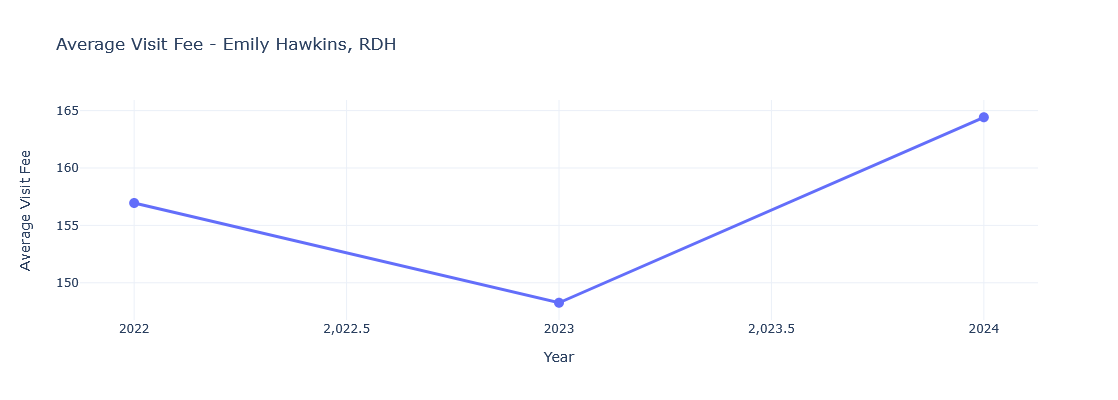


Answer: ### 1. **Direct Answer**:  
The average visit fee for Emily Hawkins, RDH:  
- **2022**: $156.95  
- **2023**: $148.26 (**-5.5%** decrease from 2022)  
- **2024**: $164.42 (**+10.9%** increase from 2023).  

### 2. **Comparative Context**:  
- **Vs. Other Hygienists**:  
  - Farah Rahman, RDH: $139–$160 (Emily’s fees are **higher** every year).  
  - "Hyg Hyg": $138–$167 (Emily’s 2024 fee is slightly below their peak).  
- **Vs. Practice Average**:  
  - Emily’s fees are **above the hygienist average** (typically $140–$160 range) but below specialty providers (e.g., DDS/DMI).  

### 3. **Key Insights**:  
- **Strengths**:  
  - 2024 fee increase suggests potential **higher-value services** or fee adjustments.  
- **Concerns**:  
  - **2023 dip** may reflect discounts, insurance changes, or less complex procedures.  
- **Implications**:  
  - Stable fees indicate **consistent patient value**, but monitor 2024’s higher fee sustainability (low patient volume that year).  

### 4. 

In [9]:
# Load data
practice_data = DentalPracticeData(
    json_file_path="demo_clinic.json",
    productivity_csv="CSVs/productivity_2022_2025_all.csv",
    procedures_csv="CSVs/procedures_2022_2025_all.csv"
)

# Test various questions - the LLM will handle them all
test_questions = [
    "What is the average visit fee for Emily Hawkins, RDH?"
]

#"What is the average visit fee for Emily Hawkins, RDH?",
#"Show me the productivity trend for Peter S. Chang, DDS",
#"What are the collection rates for Michele Chiafulio-Zasada, RDH?",
#"How many patients did Harvey Seybold, DDS see?",
#"What is the total production for Farah Rahman, RDH?"

for q in test_questions:
    print(f"\n{'='*60}")
    print(f"Question: {q}")
    result = process_question_with_visualizations(q, practice_data)
    print(f"\nAnswer: {result['answer'][:5000]}")